<a href="https://colab.research.google.com/github/pyagoubi/Motorcycle-data/blob/main/Motorcycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%%capture
pip install geopandas

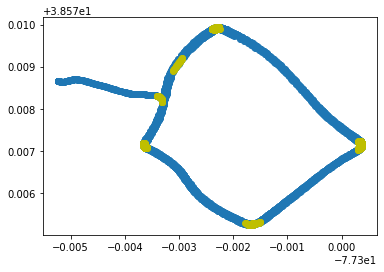

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import geopandas
import geopy.distance

data = pd.read_csv('/content/drive/MyDrive/upwork1/DATA1.TXT', sep=',')
data['Gx clean'] = data['Gx']-data['Gx Cal']
data['Gy clean'] = data['Gy']-data['Gy Cal']


#Parameters

shift_a = 30
degree_min = 50
min_samples = 50
cluster_area = 0.02


def angle_corner(df, shift_parameter = shift_a, degree_pm = degree_min):

  df['degrees'] = 0
  df['corner_a'] = 0

  for i in df['SessionID'].unique():
    
    
    data = df[df['SessionID'] == i]

    # Convert the points to numpy latitude/longitude radians space

    data['Lat converted'] = np.radians(data['Latitude'])
    data['Lon converted'] = np.radians(data['Longitude'])

    #past reference point
    data['Lat before'] = data['Lat converted'].shift(shift_parameter)
    data['Lon before'] = data['Lon converted'].shift(shift_parameter)

    #future reference point
    data['Lat after'] = data['Lat converted'].shift(-shift_parameter)
    data['Lon after'] = data['Lon converted'].shift(-shift_parameter)


    # Vectors in latitude/longitude space
    data['vector prev'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat before', 'Lon before']])).tolist()
    data['vector past'] = (np.array(data[['Lat converted', 'Lon converted']]) - np.array(data[['Lat after', 'Lon after']])).tolist()


    for j in range(len(data)):
      if np.isnan(data['vector prev'][j][0]) == False:
        data.iloc[j, data.columns.get_loc('degrees')] = np.degrees(math.acos(np.dot(data['vector prev'][j], data['vector past'][j]) / (np.linalg.norm(data['vector prev'][j]) * np.linalg.norm(data['vector past'][j]) +1e-20)))
        #print(data.iloc[i, data.columns.get_loc('degrees')])
    
    data.loc[(data['degrees'] < (180 - degree_pm) )  |  (data['degrees'] > (180 + degree_pm) )    , 'corner_a'] = 1

    df.loc[df['SessionID'] == i, 'corner_a'] = data['corner_a']
    df.loc[df['SessionID'] == i, 'degrees'] = data['degrees'] 


  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['corner_a'] == 1), 'Longitude'], y=df.loc[(df['corner_a'] == 1),'Latitude'], color = 'y')  

  return df

data = angle_corner(data, shift_parameter = shift_a, degree_pm = degree_min)

# Identifying true corners with DBSCAN


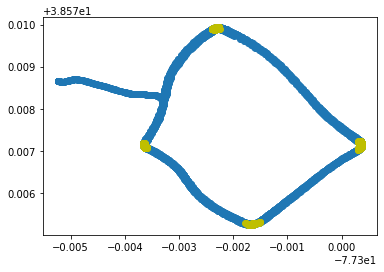

In [144]:
def true_corners(df, min_samples=min_samples, cluster_area = cluster_area):
  
  coords = df.loc[df['corner_a']==1, ['Longitude', 'Latitude']]
  db = DBSCAN(eps=cluster_area/6371., min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(df.loc[df['corner_a']==1, ['Longitude', 'Latitude']]))

  cluster_labels = db.labels_

  df['Corner Number'] = -1
  num_clusters = len(set(cluster_labels))
  clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

  df.loc[df['corner_a']==1, 'Corner Number'] = cluster_labels

  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['Corner Number'] >= 0), 'Longitude'], y=df.loc[(df['Corner Number'] >= 0),'Latitude'], color = 'y') 

  return df

data = true_corners(data)


# Determine Reference points 

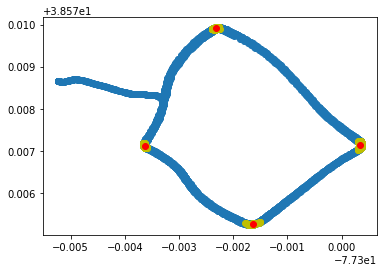

In [145]:
def centroids(df):

  corners_df = pd.DataFrame()

  centroid_x = []
  centroid_y = []

  corners = df['Corner Number'].unique().tolist()
  corners.remove(-1)

  for corner in corners:
    point = MultiPoint(geopandas.points_from_xy(df.loc[df['Corner Number'] == corner,'Longitude'], df.loc[df['Corner Number'] == corner, 'Latitude'] , crs="EPSG:4326" ))
    centroid_x.append(point.centroid.x)
    centroid_y.append(point.centroid.y)
    del point
  
  corners_df['Corner Nr'] = corners
  corners_df['Longitude'] = centroid_x
  corners_df['Latitude'] = centroid_y

  plt.scatter(x=df['Longitude'], y=df['Latitude'])
  plt.scatter(x=df.loc[(df['Corner Number'] >= 0), 'Longitude'], y=df.loc[(df['Corner Number'] >= 0),'Latitude'], color = 'y') 
  plt.scatter(x=corners_df['Longitude'], y=corners_df['Latitude'], color = 'r')

  return corners_df

reference_points = centroids(data)



#Determine Breaking Points

Breaking points are considered local speed minima within a range of *proximity* meters within a corner reference point. Ths is considered the endpoint of the breaking and starting point of acceleration.

In [157]:
# Calculate distances between reference points and track

def distances(df, ref):
  distances=[]
  corner_no = reference_points['Corner Nr']
  
  for i in corner_no:
    corner_lon = ref.loc[ref['Corner Nr']== i , 'Longitude'].values[0]
    corner_lat = ref.loc[ref['Corner Nr']== i , 'Latitude'].values[0]
    cent = (corner_lat,corner_lon)
    for j in range(len(data)):
      dist = geopy.distance.geodesic(cent, coordinates[j]).m   
      distances.append(dist)
    df[f'Distance from corner {i}'] = distances
    distances=[]

  return df
       

In [158]:
data = distances(data, reference_points)

In [159]:
#All values after passing the closest point to centroid are multiplied by -1
def adjust_distance(df, corner_no): 
  df['most_controid'] = 0
  
  for j in corner_no:
    minids = df.groupby('Lap Number')[f'Distance from corner {j}'].apply(lambda x: x.idxmin())
    for i in df['Lap Number'].unique():
      df.loc[(df.index <= minids[i])  & (df['Lap Number'] == i) ,f'Distance from corner {j}'] *= -1
      df.loc[df.index == minids[i],  'most_controid'] = j
  
  return df



In [160]:
corner_no = reference_points['Corner Nr']
data = adjust_distance(data, corner_no)

In [166]:
#plot

def corner_behaviour(df,  corner_no):

  corner_df = pd.DataFrame()

  for i in corner_no:


    data.loc[((data['Distance from corner 0'] <200) &  (data['Distance from corner 0'] >= 0))  | 
                               ((data['Distance from corner 0'] > -50) &  (data['Distance from corner 0'] < 0)), 'Speed'], 'Distance from corner 0')



sns.lineplot('Distance from corner 0', 'value', hue='variable', 
             data=pd.melt(data.loc[((data['Distance from corner 0'] <200) &  (data['Distance from corner 0'] > 0))  | 
                               ((data['Distance from corner 0'] > -50) &  (data['Distance from corner 0'] < 0)), 'Speed'], 'Distance from corner 0'))

AttributeError: ignored

In [167]:
data.loc[((data['Distance from corner 0'] <200) &  (data['Distance from corner 0'] > 0))  | 
                               ((data['Distance from corner 0'] > -50) &  (data['Distance from corner 0'] < 0)), 'Speed']

63      24.45
64      24.24
65      24.32
66      24.30
67      24.16
        ...  
3402    49.53
3403    50.28
3404    50.77
3405    51.27
3406    52.63
Name: Speed, Length: 877, dtype: float64

<AxesSubplot:xlabel='Distance from corner 2', ylabel='Speed'>

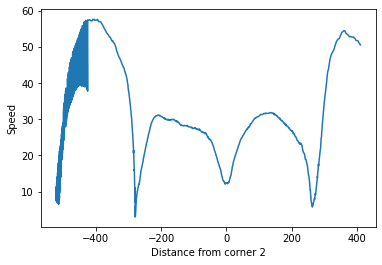

In [162]:
sns.lineplot(data=data[data['Lap Number']==3], x='Distance from corner 2', y='Speed')